# Model Building
- Objetivo do projeto:

* Entender quais variáveis são mais precisas para prevermos a variável (GOLS + ASSISTÊNCIAS)
* Entender quais estatísticas impactam mais no resultado ofensivo de um jogador
* Podermos fazer uma previsão futura de um campeonato de um jogador baseado nas suas estatísticas de um campeonato anterior


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV


In [2]:
# Importando os dados de todos jogadores

df = pd.read_csv('DadosLimpos/DadosTratados.csv')

# Seleção das variáveis para o modelo

* Selecionando as variáveis ofensivas observadas na EDA que façam sentido explicar a variável 'G+A' para iniciarmos a seleção das variáveis

* Idade
* Minutos
* PrgCarregadas
* PrgPasses
* PrgPassesPrgRecebidos
* PassesConcluidosMedio
* PassesConcluidosLongo
* DistTotalProgressivos
* ChutesAGol
* TotalChutes
* CobrancaFalta
* DistanciaChute
* Confrontos_3ter
* Desarme


In [3]:
# Criação de nova variável

df['Progressividade'] = df.PrgCarregadas*df.PrgPasses*df.PrgPassesPrgRecebidos

In [4]:
# Criando novo DF apenas com as variáveis que façam sentido para o modelo num primeiro momento

teste_variavel = df[['G+A' ,'Idade','Minutos','PrgCarregadas','PrgPasses','PrgPassesPrgRecebidos','PassesConcluidosMedio',
             'PassesConcluidosLongo','DistTotalProgressivos','ChutesAGol','TotalChutes','CobrancaFalta','DistanciaChute','Confrontos_3ter','Desarme','Progressividade']]

In [5]:
def filtrar_e_visualizar_correlacao(df, threshold, drop_column = None):

    # Calcula a matriz de correlação
    corr = df.corr()
    
    # Aplica os filtros de limiar, excluindo a correlação perfeita
    filtro = (abs(corr) >= threshold) & (corr != 1.0)
    df_filtrado = corr.where(filtro).dropna(how = 'all').dropna(axis = 1, how = 'all')
    
    # Remove a coluna e linha especificada, se fornecido
    if drop_column:
        df_filtrado = df_filtrado.drop(index = drop_column, 
                                       errors = 'ignore').drop(columns = drop_column, 
                                                               errors = 'ignore')
    
    # Visualiza o resultado com um heatmap somente com as variáveis que satisfazem o critério de filtro
    plt.figure(figsize = (8, 6))
    sns.heatmap(df_filtrado, annot = True, cmap = 'coolwarm', center = 0)
    plt.show()

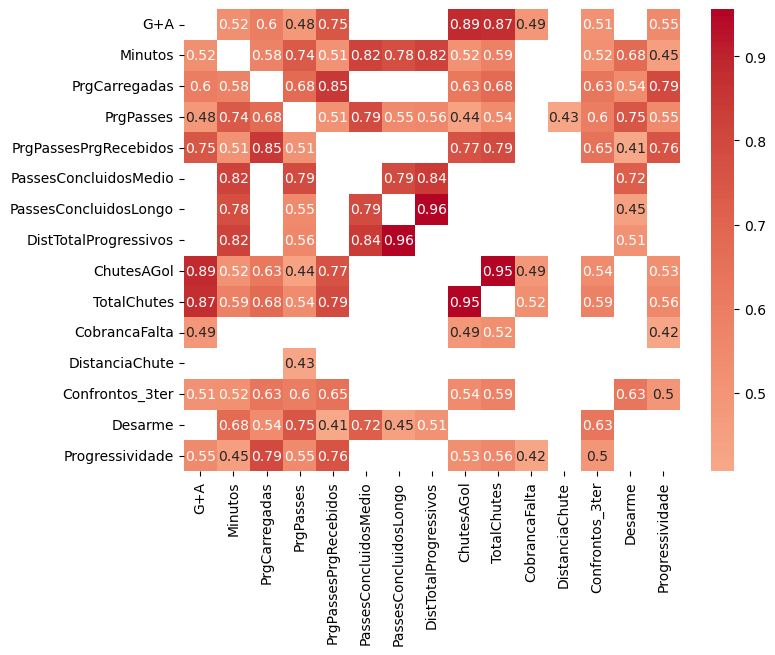

In [6]:
filtrar_e_visualizar_correlacao(teste_variavel,0.4,drop_column=None)

* As variáveis que mais possuem maior correlação com a variável G+A são: 
- Minutos
- PrgCarregadas
- PrgPasses
- PrgPassesPrgRecebidos
- ChutesAGol
- TotalChutes
- CobrancaFalta
- Confrontos_3ter

# Checando MULTICOLINEARIDADE e tomando decisões

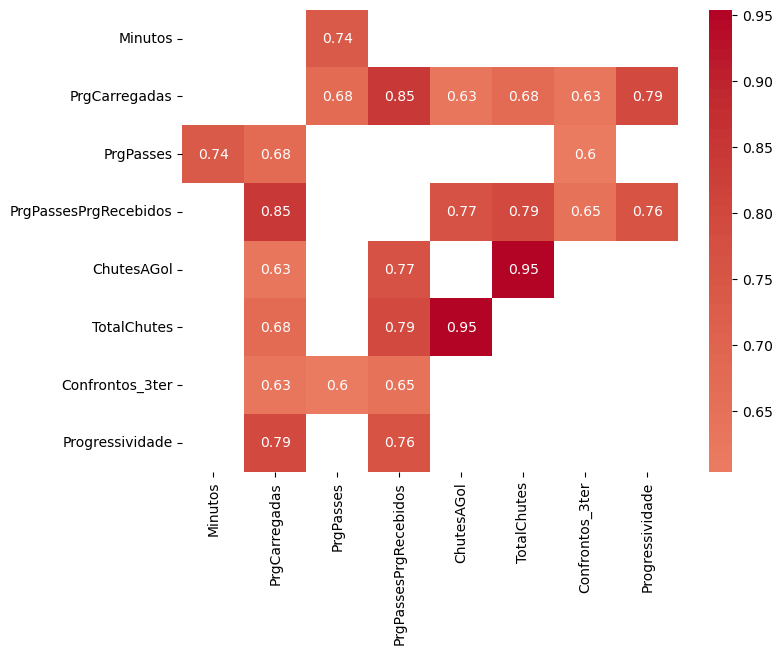

In [7]:
teste_variavel = teste_variavel[[
    "Minutos",
    "PrgCarregadas",
    "PrgPasses",
    "PrgPassesPrgRecebidos",
    "ChutesAGol",
    "TotalChutes",
    "CobrancaFalta",
    "Confrontos_3ter",
    'Progressividade'
]]
filtrar_e_visualizar_correlacao(teste_variavel,threshold=0.6,drop_column='G+A')

# Decisões tomadas:
* Remover a variável TotalChutes devido a ter uma correlação menor do que a ChutesAGol.
* Remover as variáveis 'Prg' e manter apenas a progressividade que engloba as 3.

# Resolução final
*As variáveis do modelo serão Minutos, ChutesAGol, Confrontos_3ter e Progressividade

# Criando DF para a modelagem

In [8]:
df_modeling = df[['Jogador','Equipe','Idade','G+A','Minutos','ChutesAGol','Confrontos_3ter','Progressividade']]
for coluna in df_modeling.columns[5:]:  
    df_modeling[coluna] = df[coluna] / df['Minutos']

C:\Users\bruno\AppData\Local\Temp\ipykernel_22544\790318335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modeling[coluna] = df[coluna] / df['Minutos']


In [9]:
df_modeling.head()

,Jogador,Equipe,Idade,G+A,Minutos,ChutesAGol,Confrontos_3ter,Progressividade
0,Nicolás Acevedo,Bahia,23.0,0.0,1970.0,0.002030,0.003046,59.354315
1,Luiz Adriano,Internacional,35.0,4.0,1330.0,0.008271,0.004511,2.542105
2,Adriel,Grêmio,22.0,0.0,180.0,0.000000,0.000000,0.000000
3,Adryelson,Botafogo (RJ),24.0,2.0,2996.0,0.001669,0.000334,0.112150
4,Adson,Corinthians,22.0,1.0,857.0,0.003501,0.003501,206.063011


* Neste novo DF nós obteremos todas as variáveis por minuto jogado, assim observaremos o real impacto de cada jogador por minuto jogado.

# Definindo as variáveis independentes e a variável dependente

In [10]:
# Mapeando as variáveis

X = df_modeling[['Minutos','ChutesAGol','Confrontos_3ter','Progressividade']]
y = df_modeling['G+A']

# Usando train_test_split para separarmos a base de dados 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criando painel de visualização das estatísticas do modelo

In [11]:
def print_results(y_true, y_pred):
    # Calcula as métricas de avaliação
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calcula os resíduos
    residuals = y_true - y_pred
     
    # Calcula o MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # Retorna as métricas calculadas
    
    print('MSE:%.3F'%mse)
    print('MAE:%.3F'%mae)
    print('R²:%.3F'%r2)
    print('Pearson_Corr:%.3F'%pearson_corr)
    print('MAPE:%.3F'%mape)
    print('  ')
    
    return mse, mae, r2, pearson_corr, mape
    

# Pré-processamento dos dados, padronizando os dados

In [12]:
# Importando o padronizador
scaler = StandardScaler()
# Fitando a base de treino
scaler.fit(X_train)
# Aplicando o scaler nas variáveis de treino e teste
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelagens preditivas

# Modelo 1 - Regressão Linear

In [13]:
modelo_v1 = LinearRegression()

modelo_v1.fit(X_train_scaled, y_train)

y_preds_train_v1 = modelo_v1.predict(X_train_scaled)
# Print das métricas em treino
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v1))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v1))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v1)))
print('R2 Score:', r2_score(y_train, y_preds_train_v1))

Mean Absolute Error: 1.4053557549419184
Mean Squared Error: 5.1662855320703525
Root Mean Squared Error: 2.2729464428512944
R2 Score: 0.5170379944481822


# Avaliando o modelo

In [14]:
y_preds_test_v1 = modelo_v1.predict(X_test_scaled)

df_previsoes = pd.DataFrame({'Valor_Real': y_test, 'Valor_Previsto': (y_preds_test_v1.round())})
df_previsoes.sample(10)

,Valor_Real,Valor_Previsto
55,0.0,-0.0
73,2.0,3.0
210,11.0,6.0
69,2.0,1.0
446,0.0,-1.0
136,5.0,3.0
346,0.0,0.0
356,0.0,2.0
70,7.0,3.0
51,0.0,1.0


In [15]:
# Função para criar gráfico de dispersão
def cria_scatter(x, y, title, xlabel, ylabel):
    
    # Figura e subplots
    fig, ax = plt.subplots(figsize = (10, 6))
    
    # Scatter
    ax.scatter(x, y, color = "blue", alpha = 0.3)

    # Labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return

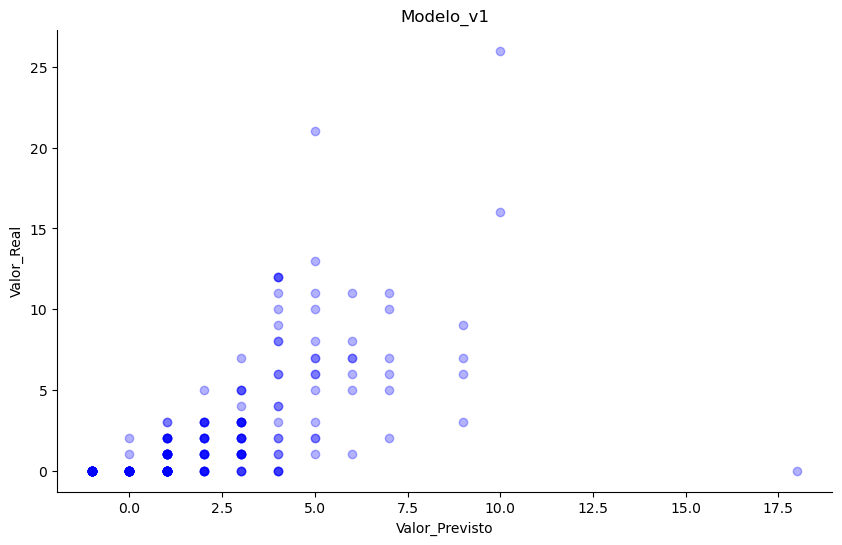

In [16]:
cria_scatter(df_previsoes['Valor_Previsto'],df_previsoes['Valor_Real'],'Modelo_v1','Valor_Previsto', 'Valor_Real')

In [17]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v1))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v1))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v1)))
print('R2 Score:', r2_score(y_test, y_preds_test_v1))

Mean Absolute Error: 1.595629618391706
Mean Squared Error: 8.016652680428209
Root Mean Squared Error: 2.83136940020694
R2 Score: 0.4220156653060646


# Versão 2 do Modelo - Regressão Lasso (Regularização L1)

In [18]:
from sklearn.linear_model import Lasso

modelo_v2 = Lasso(alpha =1.0)
modelo_v2.fit(X_train_scaled,y_train)
y_preds_train_v2 = modelo_v2.predict(X_train_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v2))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v2))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v2)))
print('R2 Score:', r2_score(y_train, y_preds_train_v2))

Mean Absolute Error: 1.7504676060332127
Mean Squared Error: 7.396504021386128
Root Mean Squared Error: 2.719651452187601
R2 Score: 0.3085495576917554


In [19]:
y_preds_test_v2 = modelo_v2.predict(X_test_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v2))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v2))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v2)))
print('R2 Score:', r2_score(y_test, y_preds_test_v2))


Mean Absolute Error: 1.981941545248628
Mean Squared Error: 10.16343717143762
Root Mean Squared Error: 3.18801461280177
R2 Score: 0.26723687480206393


# Versão 3 do Modelo - Regressão Ridge (Regularização L2)

In [20]:
modelo_v3 = Ridge(alpha = 1.0)  
modelo_v3.fit(X_train_scaled,y_train)
y_preds_train_v3 = modelo_v3.predict(X_train_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v3))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v3))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v3)))
print('R2 Score:', r2_score(y_train, y_preds_train_v3))

Mean Absolute Error: 1.40442556996102
Mean Squared Error: 5.166296326946272
Root Mean Squared Error: 2.272948817493758
R2 Score: 0.5170369853063352


In [21]:
y_preds_test_v3 = modelo_v3.predict(X_test_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v3))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v3))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v3)))
print('R2 Score:', r2_score(y_test, y_preds_test_v3))

Mean Absolute Error: 1.5947381875624194
Mean Squared Error: 8.014788946430302
Root Mean Squared Error: 2.8310402587088555
R2 Score: 0.4221500367323653


# Versão 4 do Modelo - Regressão ElasticNet

In [22]:

modelo_v4 = ElasticNet(alpha=1.0,l1_ratio=1.0)
modelo_v4.fit(X_train_scaled,y_train)
y_preds_train_v4 = modelo_v4.predict(X_train_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v4))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v4))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v4)))
print('R2 Score:', r2_score(y_train, y_preds_train_v4))

Mean Absolute Error: 1.7504676060332127
Mean Squared Error: 7.396504021386128
Root Mean Squared Error: 2.719651452187601
R2 Score: 0.3085495576917554


In [23]:
y_preds_test_v4 = modelo_v4.predict(X_test_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v4))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v4))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v4)))
print('R2 Score:', r2_score(y_test, y_preds_test_v4))

Mean Absolute Error: 1.981941545248628
Mean Squared Error: 10.16343717143762
Root Mean Squared Error: 3.18801461280177
R2 Score: 0.26723687480206393


# Versão 5 do Modelo - Versão com Otimização dos Hiperparâmetros

In [24]:
modelo_v5 = Ridge()
parametros = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search_dsa = GridSearchCV(estimator = modelo_v5, 
                               param_grid = parametros, 
                               cv = 5, 
                               scoring = 'neg_mean_squared_error', 
                               verbose = 1)

grid_search_dsa.fit(X_train_scaled, y_train)

melhor_modelo = grid_search_dsa.best_estimator_

y_preds_train_v5 = melhor_modelo.predict(X_train_scaled)

# Métricas em treino
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v5))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v5))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v5)))
print('R2 Score:', r2_score(y_train, y_preds_train_v5))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mean Absolute Error: 1.341497283705066
Mean Squared Error: 5.248273069612789
Root Mean Squared Error: 2.2909109693772014
R2 Score: 0.5093735195917408


In [25]:
y_preds_test_v5 = melhor_modelo.predict(X_test_scaled)

# Métricas com dados de teste
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v5))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v5))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v5)))
print('R2 Score:', r2_score(y_test, y_preds_test_v5))

# Imprime o melhor hiperparâmetro
print('Melhor alpha:', grid_search_dsa.best_params_['alpha'])

Mean Absolute Error: 1.539786241221274
Mean Squared Error: 7.9733433666828
Root Mean Squared Error: 2.8237109212316334
R2 Score: 0.4251381786403773
Melhor alpha: 100


# Versão 6 do Modelo - Random Forest Regressor

In [26]:
modelo_v6 = RandomForestRegressor()

modelo_v6.fit(X_train_scaled,y_train)
y_preds_train_v6 = modelo_v6.predict(X_train_scaled)

# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v6))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v6))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v6)))
print('R2 Score:', r2_score(y_train, y_preds_train_v6))

Mean Absolute Error: 0.3676772582972583
Mean Squared Error: 0.40338143005730953
Root Mean Squared Error: 0.6351231613296034
R2 Score: 0.9622905270617579


In [27]:
y_preds_test_v6 = modelo_v6.predict(X_test_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v6))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v6))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v6)))
print('R2 Score:', r2_score(y_test, y_preds_test_v6))

Mean Absolute Error: 1.0941866356357506
Mean Squared Error: 3.7677373120955293
Root Mean Squared Error: 1.9410660246615852
R2 Score: 0.7283538116912993


# Versão 7 do Modelo - XGBoost

In [28]:
modelo_v7 = xgb.XGBRegressor()

modelo_v7.fit(X_train_scaled,y_train)
y_preds_train_v7 = modelo_v7.predict(X_train_scaled)


# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_train, y_preds_train_v7))
print('Mean Squared Error:', mean_squared_error(y_train, y_preds_train_v7))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_preds_train_v7)))
print('R2 Score:', r2_score(y_train, y_preds_train_v7))

Mean Absolute Error: 0.026794880568895244
Mean Squared Error: 0.004811870596120659
Root Mean Squared Error: 0.06936764805095139
R2 Score: 0.9995501699123805


In [29]:
y_preds_test_v7 = modelo_v7.predict(X_test_scaled)
# Avalie o desempenho do modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v7))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v7))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v7)))
print('R2 Score:', r2_score(y_test, y_preds_test_v7))

Mean Absolute Error: 1.1356179672416349
Mean Squared Error: 3.573018058150694
Root Mean Squared Error: 1.8902428569236
R2 Score: 0.7423926734119987


# Versão 8 do Modelo - Random Forest Regressor com otimização de parâmetros

In [30]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest Regressor
modelo_v8 = RandomForestRegressor()

# Perform grid search
grid_search = GridSearchCV(modelo_v8, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for evaluation
best_model = grid_search.best_estimator_
y_preds_test_v8 = best_model.predict(X_test_scaled)

# Evaluate the best model
print('Test Set R2 Score:', r2_score(y_test, y_preds_test_v8))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_preds_test_v8)))
print('Mean Squared Error:', mean_squared_error(y_test, y_preds_test_v8))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_preds_test_v8))


Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Test Set R2 Score: 0.7249685132642477
Root Mean Squared Error: 1.953123513658266
Mean Squared Error: 3.814691459604811
Mean Absolute Error: 1.1062177010550904


# Seleção do modelo

In [31]:
# R2 Score
r2_score_v1 = r2_score(y_test, y_preds_test_v1)
r2_score_v2 = r2_score(y_test, y_preds_test_v2)
r2_score_v3 = r2_score(y_test, y_preds_test_v3)
r2_score_v4 = r2_score(y_test, y_preds_test_v4)
r2_score_v5 = r2_score(y_test, y_preds_test_v5)
r2_score_v6 = r2_score(y_test, y_preds_test_v6)
r2_score_v7 = r2_score(y_test, y_preds_test_v7)
r2_score_v8 = r2_score(y_test, y_preds_test_v8)

# MSE
mse_v1 = mean_squared_error(y_test, y_preds_test_v1)
mse_v2 = mean_squared_error(y_test, y_preds_test_v2)
mse_v3 = mean_squared_error(y_test, y_preds_test_v3)
mse_v4 = mean_squared_error(y_test, y_preds_test_v4)
mse_v5 = mean_squared_error(y_test, y_preds_test_v5)
mse_v6 = mean_squared_error(y_test, y_preds_test_v6)
mse_v7 = mean_squared_error(y_test, y_preds_test_v7)
mse_v8 = mean_squared_error(y_test, y_preds_test_v8)

* Criando visualização intuitiva dos resultados

In [32]:
modelos = ['Regressão Linear v1', 'Lasso v2', 'Ridge v3', 'ElasticNet v4', 'Ridge Otimizado v5', 'Random Forest Regressor v6', 'XGBoost v7', 'Random Forest Regressor Otimizado v8']
r2_scores = [r2_score_v1, r2_score_v2, r2_score_v3, r2_score_v4, r2_score_v5, r2_score_v6, r2_score_v7, r2_score_v8]
mse = [mse_v1, mse_v2, mse_v3, mse_v4, mse_v5, mse_v6, mse_v7, mse_v8]

modelos = pd.DataFrame({
    'Modelo': modelos,
    'R2 Score': r2_scores,
    'Mean Squared Erros': mse
})

modelos.sort_values(by='R2 Score', ascending=False)

,Modelo,R2 Score,Mean Squared Erros
6,XGBoost v7,0.742393,3.573018
5,Random Forest Regressor v6,0.728354,3.767737
7,Random Forest Regressor Otimizado v8,0.724969,3.814691
4,Ridge Otimizado v5,0.425138,7.973343
2,Ridge v3,0.422150,8.014789
0,Regressão Linear v1,0.422016,8.016653
1,Lasso v2,0.267237,10.163437
3,ElasticNet v4,0.267237,10.163437


* O modelo que mais performa prevendo a variável dependente é o modelo 7, o modelo XGBoost.
* Além de ter o maior R2_Score também apresenta o menor erro entre os modelos. 
* Portanto este será o modelo escolhido.

# Análise de resíduos

In [33]:
# Extraindo os resíduos de treino e de teste.
residuos_train = y_train - y_preds_train_v7
residuos_test = y_test - y_preds_test_v7

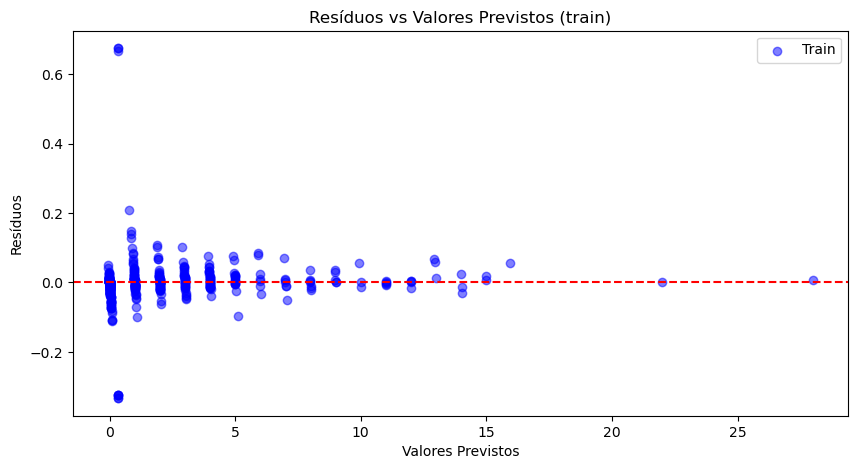

In [34]:
# Plotando os resíduos de treino

plt.figure(figsize=(10,5))
plt.scatter(y_preds_train_v7, residuos_train,color='blue', label='Train', alpha=0.5)
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Previstos (train)')
plt.legend()
plt.show()

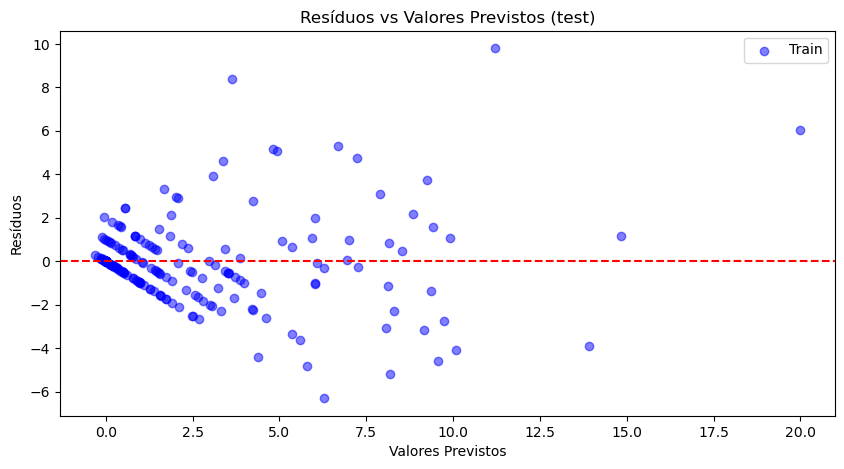

In [35]:
# Plotando os resíduos de teste
plt.figure(figsize=(10,5))
plt.scatter(y_preds_test_v7, residuos_test,color='blue', label='Train', alpha=0.5)
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Previstos (test)')
plt.legend()
plt.show()

* Fazendo a análise concluímos que os erros são sim aleatórios, portanto o modelo está performando bem. 

# Com isto o modelo estaria pronto para fazermos o deploy.

* A utilização deste modelo se daria para fazermos análise de performance de um jogador numa quantia de jogos e deduzir quantos 'Gols+Assistências' ele teria no fim do torneio.
* Como as estátisticas estão dispostas por minutagem, a quantidade de jogos não seria um empecilho na hora de usarmos o modelo.
